### Simulation of Spiking neural netwotk of Leaky Integrate and Fire neurons
#### Gianni Valerio Vinci 

In [4]:
#Gain Function fast and robust by M. Mattia
import numpy as np
import mpmath as mp
DawsonF=lambda x: (mp.sqrt(mp.pi)/2)*mp.exp(-(x**2))*mp.erfi(x)

def G(w):
	if(w>=-3):
		return mp.exp(w**2)*(mp.erf(w)+1)
	else:
		f=lambda y: mp.exp(-y**2)*mp.exp(2*y*w)
		return (2/mp.sqrt(mp.pi))*mp.quad(f,[0,5])

MFPT1=lambda a,b: mp.sqrt(mp.pi)*mp.quad(G,[a,b])

def MFPT2(a,b):
	MFPTfrom0=lambda b: mp.sqrt(mp.pi)*DawsonF(b)*G(b) - 2*mp.quad(DawsonF,[0,b])
	MFPTto0=lambda a: -MFPTfrom0(a)
	return MFPTfrom0(b)+MFPTto0(a)

def MFPT3(a,b):
	f=lambda w : mp.exp(-(w**2))*(mp.exp(2*b*w)-mp.exp(2*a*w))/w
	return mp.quad(f,[0,mp.inf])

def MFPT(a,b):
	if(b<=0):
		return MFPT3(a,b)

	else:
		if(b>15):
			return mp.inf

		else:
			if(a<=0):
				return MFPT3(a,0)+MFPT2(0,b)

			else:
				return MFPT2(a,b)

            
def Phi(mu,sig,Tarp,TauV,Vr,Vt):
    xr=(Vr-mu)/sig
    xt=(Vt-mu)/sig
    return np.array((1/(Tarp+TauV*MFPT(xr,xt))),dtype=float)



Nest simulation of Excitatory population:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import nest
import time
from scipy import stats
import time




def InitializeNet(nest,Net,Process,WN):

    # Network parameters
    
    Vthr     =   Net['Vt']             # Spike emission threshold (mV)
    Vres     =   Net['Vr']             # After-spike reset potential (mV)
    TauV     =   Net['TauV']*1000      # Membrane potential decay constant (ms)
    Tau0     =   Net['Tau0']*1000      # Refractory period (ms)
    Cm       =   500.                  # Membrane capacitance (pF)

    N        =   Net['N']  			   # Number of (recurrent) neurons in the network, it is an integer.
    
    Jrec  = Net['J']                   # Efficacy of the synapses from recurrent neurons (mV)
    DJ=Net['DJ']
    Krec  = Net['K']                   # Number of recurrent synapes received by a neuron

    # Simulation parameters
    dt           = Net['dt']*1000       # Integration time step (ms)
    Delay    =dt                        # Minimum spike transmission delay (ms)
    ThreadNum    = Process             # Number of simultaneous threads to launch (depends on the machine).
    TauD=Net['TauD']*1000              #[ms]
    
    Iext=0.0

    nest.ResetKernel()
    nest.SetKernelStatus({"local_num_threads": ThreadNum})
    nest.SetKernelStatus({"resolution": dt, "print_time": False})

    # Initialize the random number generators
    msd = int(np.fabs(time.process_time()*1000))
    N_vp = nest.GetKernelStatus(['total_num_virtual_procs'])[0]
    pyrngs = [np.random.RandomState(s) for s in range(msd, msd+N_vp)]
    nest.SetKernelStatus({"grng_seed" : msd+N_vp})
    nest.SetKernelStatus({"rng_seeds" : range(msd+N_vp+1, msd+2*N_vp+1)})
 
        
    # Network building: create the neurons composing the network
    neurons_exc = nest.Create("iaf_psc_delta", N, [{"V_m": Vres, "E_L": 0.0,
                                                    "C_m": Cm, "tau_m": TauV,
                                                    "V_th": Vthr, "V_reset": Vres,
                                                    "I_e": Iext, "t_ref": Tau0}])
    KExt=Net["KExt"]

    if WN:
        noise = nest.Create('noise_generator')
        mean = Cm*(Net["MuExt"]/1000.) # Infinitesimal mean (pA)
        std  = Cm *Net["SigExt"]*np.sqrt(1/(1000*dt)) # Infinitesimal SD/sqrt(dt) (pA)


        nest.SetStatus(noise, [{'mean': mean, 'std': std,
                                           'start': 0.,'dt':float(dt),'origin': 0.}])
        nest.Connect(noise, neurons_exc)
    else:
        KExt=Net["KExt"]
        JExt=Net["JExt"]
        NuExt=Net["NuExt"]

        noise=nest.Create("poisson_generator",
                    params={"rate": float(KExt*NuExt),'origin':0., 'start':0.});
        nest.Connect(noise, neurons_exc, syn_spec={'model': 'static_synapse',
                                                           'delay': dt,'weight': float(JExt)})



    # Spike detector to save simulated network activity
    spikes_detector_exc = nest.Create("spike_detector")
    nest.SetStatus(spikes_detector_exc,[{"label": 'Spikes',
                                         "withtime": True, "withgid":   False,
                                         "to_file":  False, "to_memory": True,
                                         "close_after_simulate": False}])
    conn_dict = {"rule": "all_to_all"}
    syn_dict = {"model": "static_synapse"}
    nest.Connect(neurons_exc, spikes_detector_exc, conn_dict, syn_dict)


    # Connecting recurrent neurons
    DelayDetails={"distribution": "exponential_clipped", "lambda": (1/TauD),"low":dt, "high": float('inf')}

    conn_dict_exc = {"rule": 'fixed_indegree', 'indegree': int(Krec)}
    #syn_dict_exc = {"model": "static_synapse", "weight": Jrec,"delay":DelayDetails}
    WeightsDict= {"distribution": "normal","mu": Jrec, "sigma": Jrec*DJ}

    syn_dict_exc = {"model": "static_synapse", "weight":WeightsDict,"delay":DelayDetails}
    if Krec>0:
        nest.Connect(neurons_exc, neurons_exc, conn_dict_exc, syn_dict_exc)


    return spikes_detector_exc,neurons_exc,noise

def Rate(spikes_detector_exc,Life,DeltaT,N):
    Spikes=nest.GetStatus(spikes_detector_exc)[0]["events"]["times"]
    xbins=np.arange(0,Life,DeltaT)
    counts,edges=np.histogram(Spikes,xbins)
    rate=counts/(N*DeltaT*0.001) #[Hz]
    t= edges[:-1]
    return t,rate

Stationary firing rate: 19.987537930174838
3.4292736053466797


Text(0, 0.5, 'νHz]')

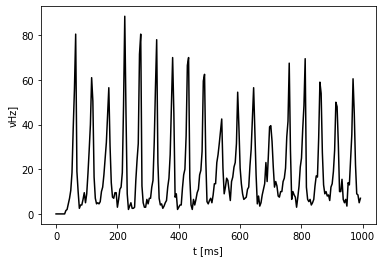

In [7]:
## Network parameters
dt=0.01/1000 #[s]
K=100 #Average number of synaptic contacts
N=500 # Number of neurons
J=8/K # Average synaptic strenght
θ,H=20.0,0.0
ntrheads=8 # !!! Set here your number of cpu core!!


τ,τ0 = 0.02,dt #[s]
τD=0.001 #[s] # mean axonal delay

#External current poisson process::
μ0=21/τ
σ0=2.66/np.sqrt(τ)
ν0=Phi(μ0*τ,σ0*np.sqrt(τ),τ0,τ,H,θ)#[Hz]
print("Stationary firing rate: "+str(ν0))

#Change external current to keep stationary firing rate at ν0
μExt=μ0-K*J*ν0
σExt=np.sqrt(σ0**2 -K*(J**2)*ν0)
CExt=5000
JExt=(σExt**2)/μExt
νExt=μExt/(CExt*JExt)

Net={"Vt":θ,"Vr":H,"K":K,"N":N,"J":J,"DJ":0.,"MuExt":μExt,"SigExt":σExt,"KExt":CExt,"JExt":JExt,"NuExt":νExt,
      "TauV":τ,"Tau0":τ0,"TauD":τD,"dt":dt}

ts=time.time()
SD,NP,IX=InitializeNet(nest,Net,ntrheads,True)
Life=1000 #[ms]
Δt=4 #[ms]
# Simulate
nest.Simulate(Life)
print(str(time.time() -ts))
t,ν=Rate(SD,Life,Δt,Net["N"])
plt.plot(t,ν,"-k")
plt.xlabel("t [ms]")
plt.ylabel("νHz]")